<a href="https://colab.research.google.com/github/erikroruiz/OCT_style_transfer/blob/main/cyclegan_oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Comprobar el entorno GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 24 10:28:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Comprobar el entorno RAM

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Instalar los paquetes necesarios

Instalamos el paquete [tensorflow_examples](https://github.com/tensorflow/examples) para poder usar su generador y su discriminador.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-xsuvlxws
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-xsuvlxws
  Created wheel for tensorflow-examples: filename=tensorflow_examples-f9dfe1d72d3a2e4ae9673eddf0e416c3c6ddaeaf_-py3-none-any.whl size=271411 sha256=5c2512f149261e15ca126f643a19a49138bcc3f00ccd0a28083591178e561722
  Stored in directory: /tmp/pip-ephem-wheel-cache-ayy_jac5/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


### Importar librerias

In [ ]:
import os
import cv2 
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from PIL import Image
from google.colab import drive
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix

AUTOTUNE = tf.data.AUTOTUNE

## Declarar las variables generales

In [ ]:
N_IMAGES = -1 # Número de imagenes a cargar de los ficheros npy. Si es -1 se cargan todas las del dataset
EPOCHS = 200
EXPERIMENT_NAME = "cycleGAN_663c_663n_unpaired_bs1"
CLEAR_DATASET_NAME_TRAIN = "clear_train_patches_663"
NOISE_DATASET_NAME_TRAIN = "noise_train_patches_663"
BUFFER_SIZE = 663


OUTPUT_CHANNELS = 3
LAMBDA = 10
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
INIT_EPOCH = 0
OPTIMIZER = "Adam" # "SGD"
# Adam optimizers parameters
LEARNING_RATE = 2e-4
BETA1=0.5

## Cargar el dataset OCT

In [ ]:
#Creamos la carpeta origen de Google Drive
BASE_FOLDER = '/content/drive/My Drive/TFM/'
# Montamos la carpeta en Google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Cargamos los ficheros npy con los dataset de entrenamiento
# Cargamos en un nparray recortes de unas imágenes sin ruido para training
clear_dataset_train = np.load(BASE_FOLDER+'datasets/train/'+CLEAR_DATASET_NAME_TRAIN+'.npy')
# Cargamos en un nparray los recortes de las imágenes con ruido para test
noise_dataset_train = np.load(BASE_FOLDER+'datasets/train/'+NOISE_DATASET_NAME_TRAIN+'.npy')
# Forma de los arrays de recortes
print("Tamaño",clear_dataset_train.shape)
print("Tamaño",noise_dataset_train.shape)

Tamaño (663, 300, 300)
Tamaño (663, 300, 300)


In [ ]:
# Si N_IMAGES = -1 cargamos todas las imágenes de los dataset, si tiene otra valor, por ejemplo 100
# sólo se cargan las 100 primeras imágenes en las lista de imágenes y etiquetas que utilizamos 
# para generar el tf.Dataset

if (N_IMAGES == -1):
  n_images_train = len(noise_dataset_train)
else:
  n_images_train = N_IMAGES

# Creamos una lista de Python a partir del nparray de imágenes con ruido de entrenamiento para poder crear el dataset de tf
noise_list_train = [] # lista vacía
for i in range (0,n_images_train):
  noise_list_train.append(cv2.cvtColor(np.uint8(noise_dataset_train[i,:,:]), cv2.COLOR_GRAY2BGR))
print(len(noise_list_train))

# Creamos una lista de Python a partir del nparray de imágenes sin ruido de entrenamiento para poder crear el dataset de tf
clear_list_train = [] # lista vacía
for i in range (0,n_images_train):
  clear_list_train.append(cv2.cvtColor(np.uint8(clear_dataset_train[i,:,:]), cv2.COLOR_GRAY2BGR))
print(len(clear_list_train))

# Creamos una lista de Python de etiquetas a ceros para poder crear el dataset de tf de etiquetas
labels_0_train = [] # lista vacía
for i in range (0,n_images_train):
  labels_0_train.append(0)
print(len(labels_0_train))

# Creamos una lista de Python de etiquetas a unos para poder crear el dataset de tf de etiquetas
labels_1_train = [] # lista vacía
for i in range (0,n_images_train):
  labels_1_train.append(1)
print(len(labels_1_train))

#Liberamos memoria
del noise_dataset_train
del clear_dataset_train

663
663
663
663


In [ ]:
# Creamos dos tf.dataset a partir de las listas de imágenes limpias y con ruido
noise_dataset_train = tf.data.Dataset.from_tensor_slices(noise_list_train)
clear_dataset_train = tf.data.Dataset.from_tensor_slices(clear_list_train)
# Creamos un dataset de etiquetas a ceros y otro a unos
labels_0_dataset_train = tf.data.Dataset.from_tensor_slices(labels_0_train)
labels_1_dataset_train = tf.data.Dataset.from_tensor_slices(labels_1_train)
# Añadimos las etiquetas al dataset
noise_dataset_train = tf.data.Dataset.zip((noise_dataset_train, labels_0_dataset_train))
clear_dataset_train = tf.data.Dataset.zip((clear_dataset_train, labels_1_dataset_train))
# Barajamos los dataset
# noise_dataset_train = noise_dataset_train.shuffle(buffer_size=BUFFER_SIZE)
# clear_dataset_train = clear_dataset_train.shuffle(buffer_size=BUFFER_SIZE)

print (type(noise_dataset_train))
print (type(clear_dataset_train))

<class 'tensorflow.python.data.ops.dataset_ops.ZipDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.ZipDataset'>


tf.Tensor(663, shape=(), dtype=int64)
[Image] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: (300, 300, 3)
[Label] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: ()


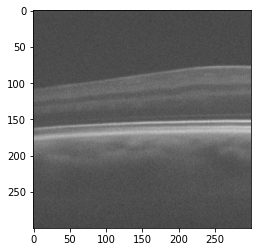

[Image] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: (300, 300, 3)
[Label] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: ()


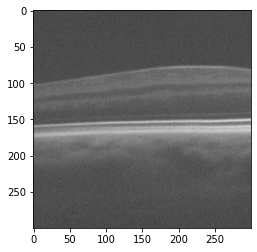

In [ ]:
# Visualizamos el dataset creado OCT
print(clear_dataset_train.__len__())  
for image, label in clear_dataset_train.take(2):
    print("[Image] type:",type(image),"- shape:",image.shape)
    print("[Label] type:",type(label),"- shape:",label.shape)
    plt.imshow(image)
    plt.show()


[Image] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: (300, 300, 3)
[Label] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: ()


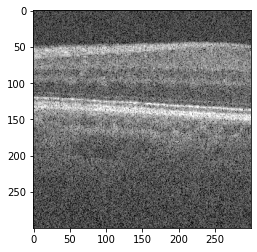

[Image] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: (300, 300, 3)
[Label] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: ()


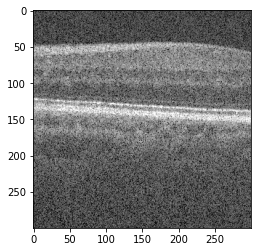

In [ ]:
# Visualizamos el dataset creado OCT
for image, label in noise_dataset_train.take(2):
    print("[Image] type:",type(image),"- shape:",image.shape)
    print("[Label] type:",type(label),"- shape:",label.shape)
    plt.imshow(image)
    plt.show()

In [ ]:
#liberamos espacio de menoria
del labels_0_train
del labels_1_train

## Funciones para transformar el dataset

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.
* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

## Aplicar las operaciones de preprocesado (transformación de las imágenes)

In [ ]:
# Apply the preprocessing operations to the training data
noise_dataset_train = noise_dataset_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

clear_dataset_train = clear_dataset_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

print(noise_dataset_train.__len__())
print(clear_dataset_train.__len__())

tf.Tensor(663, shape=(), dtype=int64)
tf.Tensor(663, shape=(), dtype=int64)


Comprobamos el tipo y tamaño de los dataset transformados

In [ ]:
print(type(noise_dataset_train))
print(noise_dataset_train.__len__())
print(type(clear_dataset_train))
print(clear_dataset_train.__len__())

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor(663, shape=(), dtype=int64)
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor(663, shape=(), dtype=int64)


Sacamos un ejemplo de cada dataset

In [ ]:
sample_noise_train = next(iter(noise_dataset_train))
sample_clear_train = next(iter(clear_dataset_train))


print(sample_noise_train.__len__())
print(sample_clear_train.__len__())

# print(type(sample_noise_train))
# print(sample_noise_train)


1
1


Transformamos el EagerTensor en un nparray

In [ ]:
print(type(sample_noise_train))
print(type(sample_clear_train))

np_noise_train = sample_noise_train.numpy()
np_clear_train = sample_clear_train.numpy()

print(type(np_noise_train))
print(type(np_clear_train))

print(np_noise_train.shape)
print(np_clear_train.shape)


<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1, 256, 256, 3)
(1, 256, 256, 3)


Ploteamos dos ejemplos de imagen antes y después del jitter (transformación) tanto con ruido y sin ruido

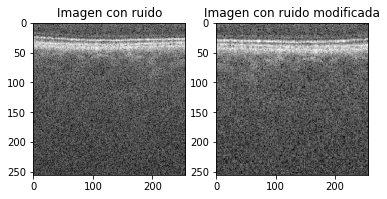

In [ ]:
# now create a subplot which represents the top plot of a grid with 1 rows and 2 column.
# 121 = (1)fila, (2)columnas, (1)era imagen
plt.subplot(121)
plt.title('Imagen con ruido')
plt.imshow(sample_noise_train[0] * 0.5 + 0.5)
# 122 = (1)fila, (2)columnas, (2)a imagen
plt.subplot(122)
plt.title('Imagen con ruido modificada')
plt.imshow(random_jitter(sample_noise_train[0]) * 0.5 + 0.5)

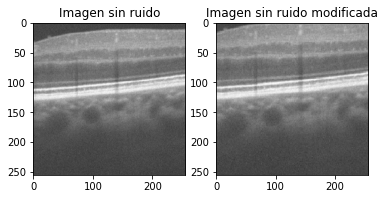

In [ ]:
plt.subplot(121)
plt.title('Imagen sin ruido')
plt.imshow(sample_clear_train[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Imagen sin ruido modificada')
plt.imshow(random_jitter(sample_clear_train[0]) * 0.5 + 0.5)

## Importamos los modelos Pix2Pix que vamos a usar como generador y discriminador

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [ ]:
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


Ejemplo de funcionamiento del generador

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


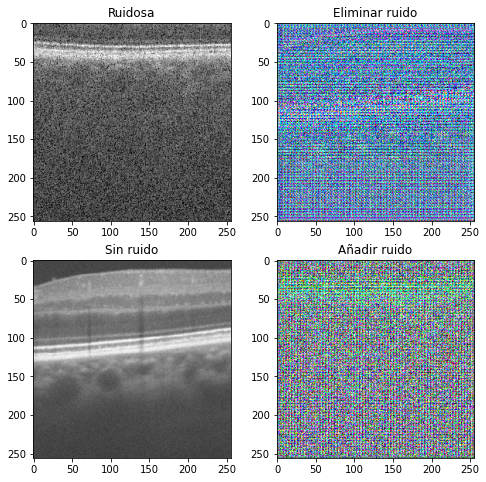

In [ ]:
to_clear = generator_g(sample_clear_train)
to_noise = generator_f(sample_noise_train)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_noise_train, to_clear, sample_clear_train, to_noise]
title = ['Ruidosa', 'Eliminar ruido', 'Sin ruido', 'Añadir ruido']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

Ejemplo de funcionamiento del discriminador

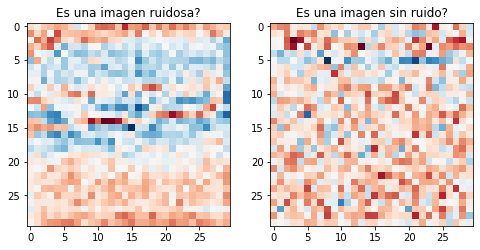

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Es una imagen ruidosa?')
plt.imshow(discriminator_y(sample_clear_train)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Es una imagen sin ruido?')
plt.imshow(discriminator_x(sample_noise_train)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA1)
generator_f_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA1)

discriminator_x_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA1)
discriminator_y_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA1)

## Checkpoints

In [ ]:
# checkpoint_path = BASE_FOLDER+"checkpoints/train"
checkpoint_path = BASE_FOLDER+''+EXPERIMENT_NAME+'/checkpoints'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  print('Restoring checkpoint')
  ckpt.restore(ckpt_manager.latest_checkpoint)
  INIT_EPOCH = int(ckpt_manager.latest_checkpoint.split(sep='ckpt-')[-1])*10
  print ('Latest checkpoint restored!!')

print("INIT_EPOCH",INIT_EPOCH)


Restoring checkpoint
Latest checkpoint restored!!
INIT_EPOCH 190


## Training


In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('on')
  plt.show()



Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
# @tf.function
def train_step(real_x, real_y, epoch):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)



    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return np.array([epoch, total_gen_g_loss.numpy(), gen_g_loss.numpy(), total_cycle_loss.numpy(), identity_loss(real_y, same_y).numpy(),
                   total_gen_f_loss.numpy(), gen_f_loss.numpy(), total_cycle_loss.numpy(), identity_loss(real_x, same_x).numpy(),
                   disc_x_loss.numpy(), disc_y_loss.numpy()])

In [ ]:
# Guardar array en disco en formato npy
def guardar_array (url_nombre, array):
    np.save(url_nombre, array)

In [ ]:
if (INIT_EPOCH == 0): # Primera vez que se ejecuta se inicializa el array de métricas
  metrics_array = np.zeros((EPOCHS,11))
  print("Entranamiento from scratch")
else: # Se carga el array de métricas desde disco
  print("Entrenamiento desde checkpoint")
  metrics_array = np.load(BASE_FOLDER+''+EXPERIMENT_NAME+'/results/metrics.npy')

print("Entrenamos desde EPOCH",INIT_EPOCH+1," hasta ",EPOCHS)

for epoch in range(INIT_EPOCH, EPOCHS):
  print("EPOCH",epoch+1)
  start = time.time()
  n = 0
  metrica = np.zeros([])
  for image_x, image_y in tf.data.Dataset.zip((noise_dataset_train, clear_dataset_train)):
    metrica = train_step(image_x, image_y, epoch+1)
    if n % 10 == 0:
      print ('>', end='')
    n += 1
  metrics_array[epoch] = metrica
  # Guardamos el array de metricas por cada epoch
  guardar_array (BASE_FOLDER+''+EXPERIMENT_NAME+'/results/metrics.npy', metrics_array)
  # clear_output(wait=True)
  
  print("G:[",metrica[1],"] - G_A:[",metrica[2],"] - cycle_A:[",metrica[3],"] - idt_A:[",metrica[4],"]")
  print("F:[",metrica[5],"] - G_B:[",metrica[5],"] - cycle_B:[",metrica[7],"] - idt_B:[",metrica[8],"]")
  print("Dx:[",metrica[9],"] - Dy:[",metrica[10],"]")

  if (epoch + 1) % 10 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
  # print (metrics_array)

# Guardamos el modelo generador G
print("Guardamos los modelos resultantes")
generator_g.save(BASE_FOLDER+'/'+EXPERIMENT_NAME+'/models') 

# Guardamos el array de parámetros
params_array = np.array([EXPERIMENT_NAME,str(BATCH_SIZE),str(EPOCHS),str(BUFFER_SIZE),OPTIMIZER])
guardar_array (BASE_FOLDER+''+EXPERIMENT_NAME+'/results/params.npy', params_array)


Entrenamiento desde checkpoint
Entrenamos desde EPOCH 191  hasta  200
EPOCH 191
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>G:[ 5.997848987579346 ] - G_A:[ 4.350734233856201 ] - cycle_A:[ 1.5345724821090698 ] - idt_A:[ 0.11254209280014038 ]
F:[ 7.5643134117126465 ] - G_B:[ 7.5643134117126465 ] - cycle_B:[ 1.5345724821090698 ] - idt_B:[ 0.17768210172653198 ]
Dx:[ 0.008690310642123222 ] - Dy:[ 0.011710667051374912 ]
Time taken for epoch 191 is 523.4558598995209 sec

EPOCH 192
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>G:[ 2.0714502334594727 ] - G_A:[ 1.2221288681030273 ] - cycle_A:[ 0.7705017328262329 ] - idt_A:[ 0.07881966233253479 ]
F:[ 5.7942914962768555 ] - G_B:[ 5.7942914962768555 ] - cycle_B:[ 0.7705017328262329 ] - idt_B:[ 0.09977933019399643 ]
Dx:[ 0.15134486556053162 ] - Dy:[ 0.5427951216697693 ]
Time taken for epoch 192 is 519.2962324619293 sec

EPOCH 193
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>G:[ 1.5342

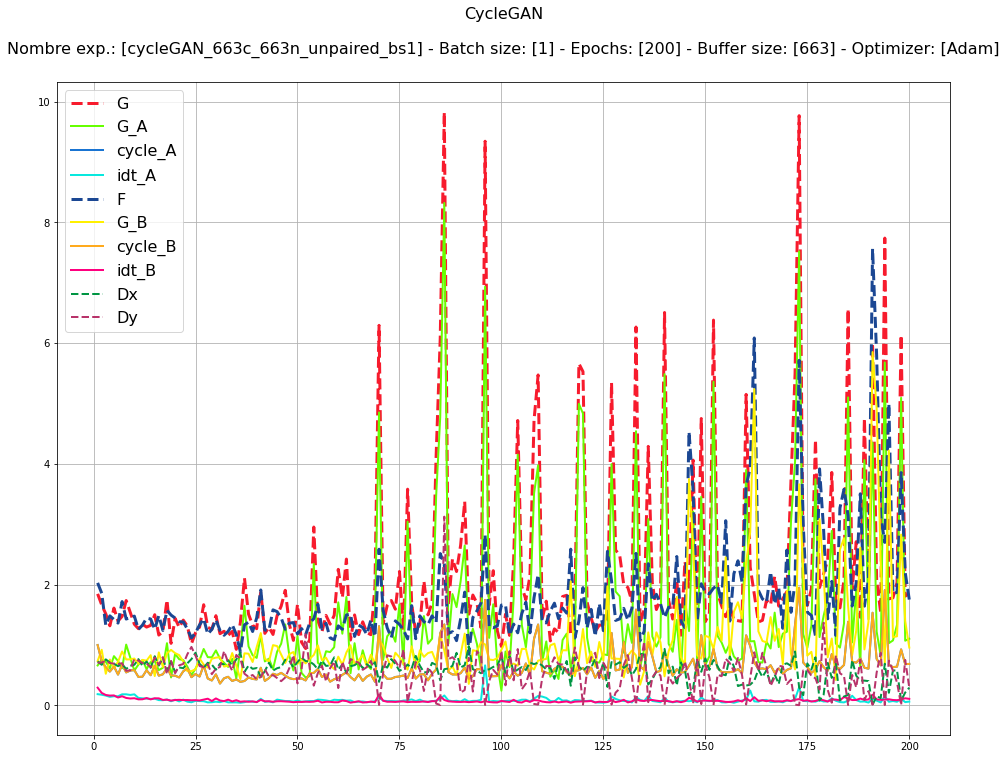

In [ ]:
metrics_array = np.load(BASE_FOLDER+''+EXPERIMENT_NAME+'/results/metrics.npy')
params_array = np.load(BASE_FOLDER+''+EXPERIMENT_NAME+'/results/params.npy')


title = "CycleGAN"
subtitle = "Nombre exp.: ["+params_array[0]+"] - Batch size: ["+params_array[1]+"] - Epochs: ["+params_array[2]+"] - Buffer size: ["+params_array[3]+"] - Optimizer: ["+params_array[4]+"]"

fig = plt.figure(figsize=(16,12))
axis = fig.add_subplot(111)

plt.title(title+'\n\n'+subtitle+'\n', fontsize=16, pad=10)

# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,1], label='G', marker='o', linewidth=3, color="#F71B2D", linestyle="dashed") 
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,2], label='G_A', marker='o', linewidth=2, color="#66FF00") 
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,3], label='cycle_A', marker='o',  linewidth=2, color="#1974D2") 
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,4], label='idt_A', marker='o',  linewidth=2, color="#08E8DE")
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,5], label='F', marker='o', linewidth=3, color="#1B4793", linestyle="dashed")
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,6], label='G_B', marker='o',  linewidth=2, color="#FFF000")
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,7], label='cycle_B', marker='o', linewidth=2, color="#FFAA1D")
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,8], label='idt_B', marker='o', linewidth=2, color="#FF007F")
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,9], label='Dx', marker='o', linewidth=2, color="#009543", linestyle="dashed")
# axis.plot(metrics_array[:,0].astype(int),metrics_array[:,10], label='Dy', marker='o',linewidth=2, color="#B8336A", linestyle="dashed")

axis.plot(metrics_array[:,0].astype(int),metrics_array[:,1], label='G', linewidth=3, color="#F71B2D", linestyle="dashed") 
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,2], label='G_A', linewidth=2, color="#66FF00") 
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,3], label='cycle_A', linewidth=2, color="#1974D2") 
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,4], label='idt_A', linewidth=2, color="#08E8DE")
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,5], label='F', linewidth=3, color="#1B4793", linestyle="dashed")
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,6], label='G_B',  linewidth=2, color="#FFF000")
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,7], label='cycle_B',  linewidth=2, color="#FFAA1D")
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,8], label='idt_B', linewidth=2, color="#FF007F")
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,9], label='Dx', linewidth=2, color="#009543", linestyle="dashed")
axis.plot(metrics_array[:,0].astype(int),metrics_array[:,10], label='Dy',linewidth=2, color="#B8336A", linestyle="dashed")

axis.legend(loc='best', fontsize=16)
plt.grid()
plt.show() 

fig.savefig(BASE_FOLDER+''+EXPERIMENT_NAME+'/results/plot.png')

